# Exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

import warnings
#suppress warnings
warnings.filterwarnings('ignore')


### Generate the receptive field.

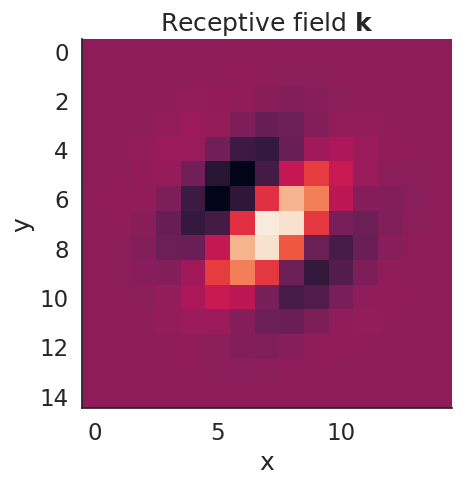

In [2]:
vf_size = (15,15)
size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc
xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))
# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))
# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)
K = G * Sn
K /= np.amax(np.abs(K))
plt.imshow(K)
plt.title(r'Receptive field $\bf{k}$')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [3]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):

        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)


def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)
        
def cc(k, khat):
    return np.dot(k, khat)/(np.linalg.norm(khat)*np.linalg.norm(k))

def estimate(duration=10, std_dev=1, spike_rate=5):
    vf_size = (15,15)
    n_bins = round(duration / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    spike_times= generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,
                                bins=np.arange(n_bins+1)*dt)[0]
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    return cc(K.ravel(), K_est[:-1])
    
#noise_variance = 1
offset = 2.
sample_rate = 10 #Hz
#spike_rate = 5 # average firing rate 
dt = 1/sample_rate
durations = [5,10,20,40,80,160,320,640] #seconds
realizations = 10
pear_ccs = []

for duration_ in durations:
    ccs = []
    for inst in range(realizations):
        ccs.append(estimate(duration=duration_))
    pear_ccs.append(np.average(ccs))
    print(f'Duration={duration_}, Averaged Pearson correlation = {pear_ccs[-1]:.3f}')

Duration=5, Averaged Pearson correlation = 0.089
Duration=10, Averaged Pearson correlation = 0.207
Duration=20, Averaged Pearson correlation = 0.323
Duration=40, Averaged Pearson correlation = 0.513
Duration=80, Averaged Pearson correlation = 0.759
Duration=160, Averaged Pearson correlation = 0.799
Duration=320, Averaged Pearson correlation = 0.965
Duration=640, Averaged Pearson correlation = 0.992


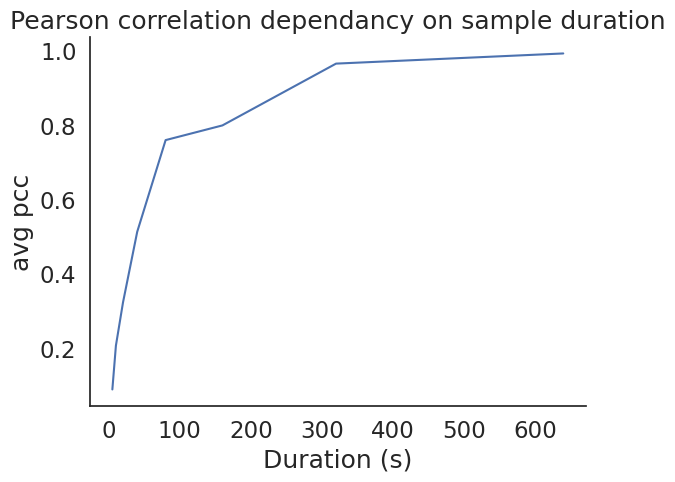

In [4]:
plt.plot(durations, pear_ccs)
plt.xlabel('Duration (s)')
plt.ylabel('avg pcc')
plt.title('Pearson correlation dependancy on sample duration')
plt.show()

The relation shown in the plot indicates a log relation between the correlation and the time duration of the stimuli. From this it can be concluded, that the quality of the recovered filter is higher with longer durations. A pcc value of 1 indicates that the recovered filter is identical to the predetermined receptive field.


## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

std_dev=0, Averaged Pearson correlation = nan
std_dev=2, Averaged Pearson correlation = 0.328
std_dev=4, Averaged Pearson correlation = 0.266
std_dev=6, Averaged Pearson correlation = 0.243
std_dev=8, Averaged Pearson correlation = 0.220
std_dev=10, Averaged Pearson correlation = 0.232


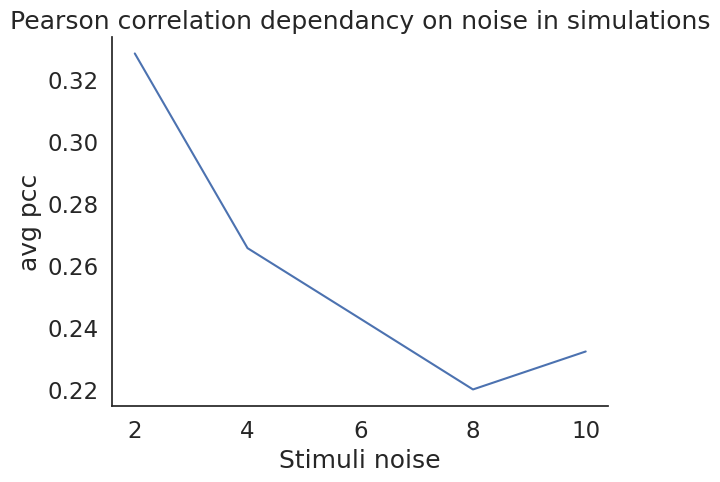

In [5]:
noises = [0,2,4,6,8,10]
fixed_duration = 100 #s
pear_ccs2 = []
for std_dev_ in noises:
    ccs = []
    for inst in range(realizations):
        ccs.append(estimate(duration=fixed_duration, std_dev=std_dev_ ))
    pear_ccs2.append(np.average(ccs))
    print(f'std_dev={std_dev_}, Averaged Pearson correlation = {pear_ccs2[-1]:.3f}')
    
plt.plot(noises, pear_ccs2)
plt.xlabel('Stimuli noise')
plt.ylabel('avg pcc')
plt.title('Pearson correlation dependancy on noise in simulations')
plt.show()

There seems to be a weak trend for the Pearson correlation coefficient to drop with higher standart derivation in the simulation stimuli.

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




The derivation can be found in the notebook of the lecture:
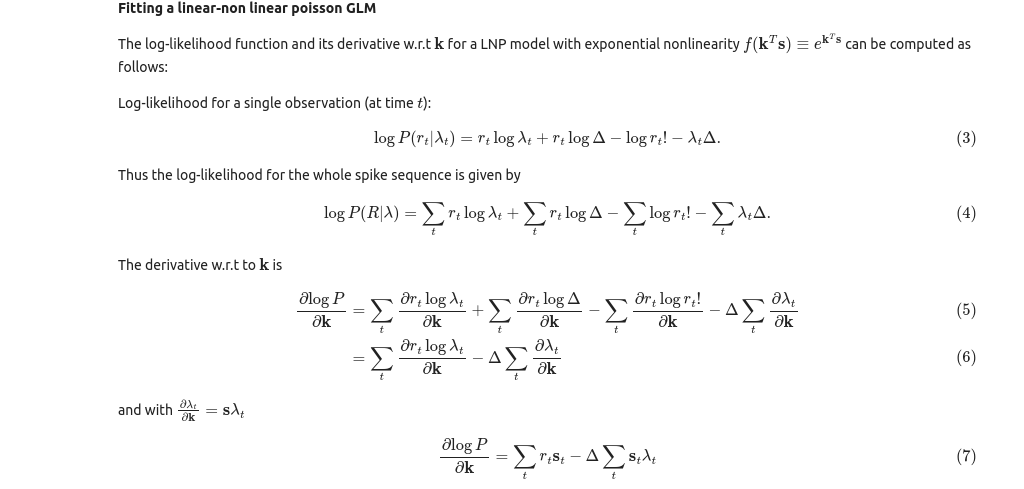 <br>
Eq5 in particular is interesting for this question as it shows all terms which affect the log-likelihood. Eq 6 shows only the terms that involve **k**.
The important terms include the dot product of the response and the stimulus minus the dot product of the expected number of spikes of the poisson process and the stimulus. This can be seen in simplified form in eq7.

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

duration=10, Averaged Pearson correlation = 0.177
duration=20, Averaged Pearson correlation = 0.321
duration=50, Averaged Pearson correlation = 0.633
duration=100, Averaged Pearson correlation = 0.774
duration=200, Averaged Pearson correlation = 0.869
spike rate=1.0, Averaged Pearson correlation = 0.608
spike rate=6.2105263157894735, Averaged Pearson correlation = 0.773
spike rate=11.421052631578947, Averaged Pearson correlation = 0.709
spike rate=16.63157894736842, Averaged Pearson correlation = 0.830
spike rate=21.842105263157894, Averaged Pearson correlation = 0.931
spike rate=27.052631578947366, Averaged Pearson correlation = 0.934
spike rate=32.26315789473684, Averaged Pearson correlation = 0.910
spike rate=37.473684210526315, Averaged Pearson correlation = 0.961
spike rate=42.68421052631579, Averaged Pearson correlation = 0.972
spike rate=47.89473684210526, Averaged Pearson correlation = 0.974
spike rate=53.10526315789473, Averaged Pearson correlation = 0.978
spike rate=58.315789

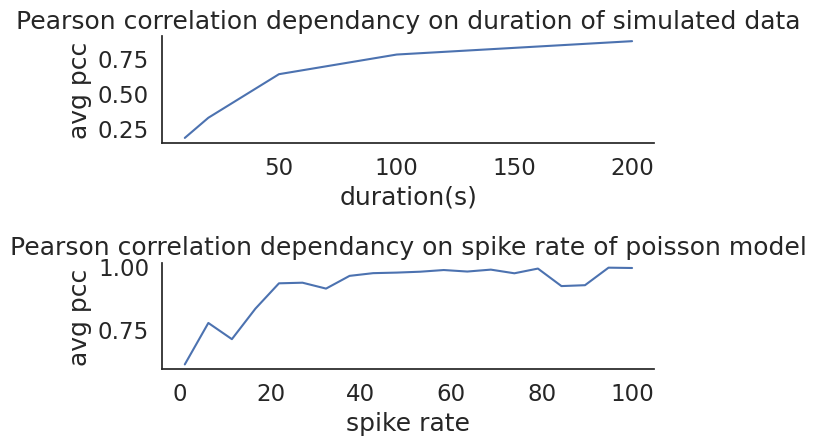

In [11]:
durations_ex4 = [10,20,50,100,200]
firing_rates = np.linspace(1,100, 20)

pear_ccs3 = []
pear_ccs4 = []
for duration_ in durations_ex4:
    ccs = []
    for inst in range(realizations):
        ccs.append(estimate(duration=duration_))
    pear_ccs3.append(np.average(ccs))
    print(f'duration={duration_}, Averaged Pearson correlation = {pear_ccs3[-1]:.3f}')
    
for rate in firing_rates:
    ccs = []
    for inst in range(realizations):
        ccs.append(estimate(duration=fixed_duration, spike_rate=rate))
    pear_ccs4.append(np.average(ccs))
    print(f'spike rate={rate}, Averaged Pearson correlation = {pear_ccs4[-1]:.3f}')
    
plt.subplot(2,1,1)
plt.plot(durations_ex4, pear_ccs3)
plt.xlabel('duration(s)')
plt.ylabel('avg pcc')
plt.title('Pearson correlation dependancy on duration of simulated data')
plt.subplot(2,1,2)
plt.plot(firing_rates, pear_ccs4)
plt.xlabel('spike rate')
plt.ylabel('avg pcc')
plt.title('Pearson correlation dependancy on spike rate of poisson model')
plt.tight_layout()
plt.show()
